In [1]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [2]:
import os

if os.getcwd() == '/content':
  % cd drive/MyDrive/exjobb_project

print(os.getcwd())
print(os.listdir('bert'))

/content/drive/MyDrive/exjobb_project
/content/drive/MyDrive/exjobb_project
['bert-base-swedish-cased', 'electra-small-swedish-cased-discriminator', 'electra-base-swedish-cased-discriminator']


In [3]:
from transformers import BertModel
from transformers import BertTokenizer
from transformers import PretrainedConfig

# metrics
from sklearn.metrics import f1_score
from sklearn.metrics import jaccard_score
from sklearn.metrics import accuracy_score
from sklearn.metrics import hamming_loss
from sklearn.metrics import multilabel_confusion_matrix

from sklearn.preprocessing import MultiLabelBinarizer
from sklearn.model_selection import train_test_split

import json
import pandas as pd
import numpy as np
import torch
import matplotlib.pyplot as plt
from torch.utils.data import Dataset, DataLoader
from torch import nn
from torch.nn import BCELoss
from collections import Counter

%matplotlib inline

In [4]:
path_to_data = './data'

# create dataframe from sessions.json
df = pd.read_json(f'{path_to_data}/sessions.json')
df.head()

# create dictionaries for switching between symptom and id
id2sym = {}
sym2id = {}

with open(f'{path_to_data}/symptoms.json') as json_file:
    data = json.load(json_file)
    for sym in data:
        id2sym[sym['id']] = sym['name']
        sym2id[sym['name']] = sym['id']
        
        
# remove labels that have less than m occurrences
m = 0

labels_list = df['confirmed'].tolist()
labels_list = sum(labels_list, [])
c = Counter(labels_list)
for i in range(len(df)):
    to_remove = []
    
    # find labels that should be removed 
    for j in range(len(df['confirmed'][i])):
        if c[df['confirmed'][i][j]] < m:
            to_remove.append(j)
            
    # remove the labels
    shift = 0
    for j in range(len(to_remove)):
        df['confirmed'][i].pop(to_remove[j]-shift)
        shift += 1
    
        
# add column with the symptom names
sym_names = []

for syms in df['confirmed']:
    if len(syms) != 0:
        sym_names.append([id2sym[x] for x in syms])
    else:
        sym_names.append([])

df['labels'] = sym_names

# remove all rows with no confirmed labels
df = df[df['confirmed'].map(len) > 0]
df = df.reset_index(drop=True)

In [5]:
df.drop('confirmed', inplace=True, axis=1)
df.drop('suggested', inplace=True, axis=1)
#df = df[0:100]
df.head()

,text,labels
0,Slut på medicin.,"[Känd astma, Känd lungsjukdom]"
1,Behöver att prata med psykolog angående använd...,"[Nedstämdhet, Trötthet]"
2,Har fått besvärlig eksem på händerna,"[Hudbesvär, Synliga hudbesvär]"
3,Muskelsvaghet och trötthet känner mig skakig o...,"[Muskelsvaghet, Trötthet]"
4,Svår smärta i vänsterhanden/handleden precis n...,"[Smärta i handled eller fingrar, Förvärras av ..."


In [6]:
# choose which transformer model to use
path_to_bert = r'./bert/electra-small-swedish-cased-discriminator'
#path_to_bert = r'./bert/electra-base-swedish-cased-discriminator'
#path_to_bert = r'./bert/bert-base-swedish-cased'

tok = BertTokenizer.from_pretrained(path_to_bert)

# train a multilabel_binarizer on the labels
labels = df['labels'].tolist()
multilab_bin = MultiLabelBinarizer()
multilab_bin.fit(labels)


class CustomDataset(Dataset):
    def __init__(self, dataframe, tokenizer, multilab_bin, max_len):
        self.tokenizer = tokenizer
        self.multilab_bin = multilab_bin
        self.data = dataframe
        self.text = self.data['text']
        self.labels = self.data['labels']
        self.max_len = max_len
        
    def __len__(self):
        return len(self.text)
    
    def __getitem__(self, index):
        text = str(self.text[index])
        text = ' '.join(text.split())
        
        inputs = self.tokenizer.encode_plus(
            text,
            None,
            add_special_tokens=True,
            max_length=self.max_len,
            truncation=True,
            padding='max_length',
            return_token_type_ids=True
        )
        ids = inputs['input_ids']
        mask = inputs['attention_mask']
        token_type_ids = inputs['token_type_ids']
        
        return {
            'ids': torch.tensor(ids, dtype=torch.long),
            'mask': torch.tensor(mask, dtype=torch.long),
            'token_type_ids': torch.tensor(token_type_ids, dtype=torch.long),
            #'labels': torch.tensor(np.sum(self.multilab_bin.transform([self.labels[index]]), axis=0), dtype=torch.float)
            'labels': torch.tensor(self.multilab_bin.transform([self.labels[index]]).reshape(-1,), dtype=torch.float)
        }        

In [7]:
batch_size = 16

# max number of tokens in text
#max_len = 200
max_len = 0
for i in range(len(df['text'])):
  text = df['text'][i]
  inputs = tok.encode_plus(
            text,
            None,
            add_special_tokens=True,
            padding=False,
            return_token_type_ids=True
            )
  if len(inputs['input_ids']) > max_len:
    max_len = len(inputs['input_ids'])
print(f'Max token length: {max_len}')


train_dataset, test_dataset = train_test_split(df,
                                        random_state=42,
                                        test_size=0.2,
                                        shuffle=True)
train_dataset = train_dataset.reset_index(drop=True)
test_dataset = test_dataset.reset_index(drop=True)

train_set = CustomDataset(train_dataset, tok, multilab_bin, max_len)
test_set = CustomDataset(test_dataset, tok, multilab_bin, max_len)

train_params = {'batch_size': batch_size,
                'shuffle': True,
                'num_workers': 0
               }
test_params = {'batch_size': batch_size,
               'shuffle': True,
               'num_workers': 0
              }

train_loader = DataLoader(train_set, **train_params)
test_loader = DataLoader(test_set, **test_params)

print(f'Train set: {len(train_dataset)} samples')
print(f'Test set: {len(test_dataset)} samples')

Max token length: 174
Train set: 3027 samples
Test set: 757 samples


In [8]:
# decide which device to use. use cuda if available
dev = ''
if torch.cuda.is_available():
    dev = 'cuda:0'
else:
    dev = 'cpu'

print(f'dev = {dev}')
print(f'Number of available GPUs: {torch.cuda.device_count()}')

# print the device names
for i in range(torch.cuda.device_count()):
  print(f'Device {i}: {torch.cuda.get_device_name(i)}')

device = torch.device(dev)

dev = cuda:0
Number of available GPUs: 1
Device 0: Tesla T4


In [9]:
class BERTClass(nn.Module):
    def __init__(self, config, path_to_bert, output_dim):
        super(BERTClass, self).__init__()
        #config = PretrainedConfig.from_json_file(f'{path_to_bert}/config.json')
        self.bert = BertModel.from_pretrained(path_to_bert)
        #self.bert = BertModel(config)
        self.dropout = torch.nn.Dropout(config.hidden_dropout_prob)
        self.fc = nn.Linear(config.hidden_size, output_dim)
        self.sigm = nn.Sigmoid()
        
    def forward(self, ids, mask, token_type_ids):
        x = self.bert(ids, attention_mask=mask, token_type_ids=token_type_ids)
        x = self.dropout(x[1])
        x = self.fc(x)
        output = self.sigm(x)
        return output

In [10]:
# compute the loss of an epoch by averaging all batch losses
def epoch_loss(model, data_loader, criterion):
    loss = 0
    batch_count = 0
    
    model.eval()
    with torch.no_grad():
        for idx,batch in enumerate(data_loader):
            ids = batch['ids'].to(device, dtype=torch.long)
            mask = batch['mask'].to(device, dtype=torch.long)
            token_type_ids = batch['token_type_ids'].to(device, dtype=torch.long)
            labels = batch['labels'].to(device, dtype=torch.float)
            
            outputs = model(ids, mask, token_type_ids)
            loss += criterion(outputs, labels)
            batch_count += 1
    model.train()
    return loss / batch_count

In [11]:
# define the model
D_out = len(multilab_bin.classes_)

config = PretrainedConfig.from_json_file(f'{path_to_bert}/config.json')

model = BERTClass(config, path_to_bert, D_out)
model.train()
model.to(device)

# number of epochs trained
epochs_trained = 0

# losses over entire train-/test-set per epoch
train_losses = []
test_losses = []

Some weights of the model checkpoint at ./bert/electra-small-swedish-cased-discriminator were not used when initializing BertModel: ['electra.embeddings.position_ids', 'electra.embeddings.word_embeddings.weight', 'electra.embeddings.position_embeddings.weight', 'electra.embeddings.token_type_embeddings.weight', 'electra.embeddings.LayerNorm.weight', 'electra.embeddings.LayerNorm.bias', 'electra.embeddings_project.weight', 'electra.embeddings_project.bias', 'electra.encoder.layer.0.attention.self.query.weight', 'electra.encoder.layer.0.attention.self.query.bias', 'electra.encoder.layer.0.attention.self.key.weight', 'electra.encoder.layer.0.attention.self.key.bias', 'electra.encoder.layer.0.attention.self.value.weight', 'electra.encoder.layer.0.attention.self.value.bias', 'electra.encoder.layer.0.attention.output.dense.weight', 'electra.encoder.layer.0.attention.output.dense.bias', 'electra.encoder.layer.0.attention.output.LayerNorm.weight', 'electra.encoder.layer.0.attention.output.Laye

In [24]:
model.train()

# training loop
learning_rate = 0.00005

criterion = torch.nn.BCELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

# if the test loss has not improved in the last k epochs, stop training
k = 5

num_epochs = 20
for epoch in range(num_epochs):
    for idx,batch in enumerate(train_loader):
        ids = batch['ids'].to(device, dtype=torch.long)
        mask = batch['mask'].to(device, dtype=torch.long)
        token_type_ids = batch['token_type_ids'].to(device, dtype=torch.long)
        labels = batch['labels'].to(device, dtype=torch.float)
        
        # forward pass
        outputs = model(ids, mask, token_type_ids)
        
        # zero the parameter gradients
        optimizer.zero_grad()
        
        # backward pass
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
    
    # save the losses
    train_losses.append(epoch_loss(model, train_loader, criterion))
    test_losses.append(epoch_loss(model, test_loader, criterion))

    epochs_trained += 1
    
    print(f'End of epoch {epochs_trained}, Train Loss: {train_losses[-1]:.7f}, Test Loss: {test_losses[-1]:.7f}')

    # if the test loss has not improved in the last k epochs break
    if len(test_losses) > k and all(test_losses[-(k+1)] < tl for tl in test_losses[-k:]):
      break

End of epoch 61, Train Loss: 0.0113513, Test Loss: 0.0246039
End of epoch 62, Train Loss: 0.0111072, Test Loss: 0.0248307
End of epoch 63, Train Loss: 0.0109023, Test Loss: 0.0245282
End of epoch 64, Train Loss: 0.0105740, Test Loss: 0.0246631
End of epoch 65, Train Loss: 0.0104459, Test Loss: 0.0243859
End of epoch 66, Train Loss: 0.0102299, Test Loss: 0.0248011
End of epoch 67, Train Loss: 0.0099374, Test Loss: 0.0246558
End of epoch 68, Train Loss: 0.0097435, Test Loss: 0.0251003
End of epoch 69, Train Loss: 0.0094243, Test Loss: 0.0246001
End of epoch 70, Train Loss: 0.0091608, Test Loss: 0.0246214


In [25]:
# get the predicitons and corresponding labels
def get_pred_true(model, data_loader, D_out):

    y_pred = np.zeros((1,D_out))
    y_true = np.zeros((1,D_out))
  
    with torch.no_grad():
        for idx,batch in enumerate(data_loader):
            ids = batch['ids'].to(device, dtype=torch.long)
            mask = batch['mask'].to(device, dtype=torch.long)
            token_type_ids = batch['token_type_ids'].to(device, dtype=torch.long)
            labels = batch['labels'].to(device, dtype=torch.float)
            
            outputs = model(ids, mask, token_type_ids)
            
            y_pred = np.concatenate((y_pred,outputs.detach().cpu().numpy()), axis=0)
            y_true = np.concatenate((y_true,np.array(labels.cpu())), axis=0)
            
    return y_pred[1:,:], y_true[1:,:]

model.eval()  
y_pred_temp, y_true = get_pred_true(model, test_loader, D_out)

./bert/electra-small-swedish-cased-discriminator
Number of labels in training set: 186/197 (94.42 %)
Number of labels in test set: 140/197 (71.07 %)
Number of labels present in both sets: 129/197 (65.48 %)

Micro-average F1-score: 0.6536553092954018
Weighted-average F1-score: 0.6205014524544166
Macro-average F1-score: 0.42898624268906116
Accuracy (exact match): 0.3632760898282695
Hamming Loss: 0.007020767255195167


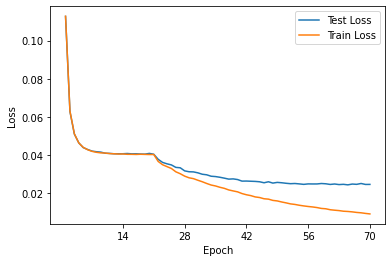

In [26]:
# set all values above threshold to 1, else 0
th = 0.2
y_pred = np.copy(y_pred_temp)
y_pred[y_pred > th] = 1
y_pred[y_pred <= th] = 0

# number of labels in test set
#labels_in_test = np.count_nonzero(np.sum(y_true, axis=0))
label_counts_test = np.sum(multilab_bin.transform(test_dataset['labels']), axis=0)
labels_in_test = np.count_nonzero(label_counts_test)

# number of labels in train set
label_counts_train = np.sum(multilab_bin.transform(train_dataset['labels']), axis=0)
labels_in_train = np.count_nonzero(label_counts_train)

# compute size of intersection between labels in train and test
label_counts_test[label_counts_test > 0] = 1
labels_bin_test = label_counts_test

label_counts_train[label_counts_train > 0] = 1
labels_bin_train = label_counts_train

labels_bin_sum = labels_bin_test + labels_bin_train
labels_intersect = np.count_nonzero(labels_bin_sum[labels_bin_sum == 2])

print(path_to_bert)
print(f'Number of labels in training set: {labels_in_train}/{y_true.shape[1]} ({labels_in_train/y_true.shape[1]*100:.2f} %)')
print(f'Number of labels in test set: {labels_in_test}/{y_true.shape[1]} ({labels_in_test/y_true.shape[1]*100:.2f} %)')
print(f'Number of labels present in both sets: {labels_intersect}/{y_true.shape[1]} ({labels_intersect/y_true.shape[1]*100:.2f} %)')
print()
print(f"Micro-average F1-score: {f1_score(y_true, y_pred, average='micro')}")
print(f"Weighted-average F1-score: {f1_score(y_true, y_pred, average='weighted', zero_division=1)}")
print(f"Macro-average F1-score: {f1_score(y_true, y_pred, average='macro', zero_division=1)}")
#print(f"Sample-average Jaccard score: {jaccard_score(y_true, y_pred, average='samples', zero_division=1)}")
print(f"Accuracy (exact match): {accuracy_score(y_true, y_pred)}")
print(f"Hamming Loss: {hamming_loss(y_true, y_pred)}")

x = [x for x in range(1,len(train_losses)+1)]
xticks = [x*len(train_losses)//5 for x in range(1,6)]
plt.plot(x, test_losses)
plt.plot(x, train_losses)
plt.legend(['Test Loss', 'Train Loss'])
plt.xticks(xticks,xticks)
plt.xlabel('Epoch')
plt.ylabel('Loss')
#plt.gca().set_ylim([0,0.1])
plt.show()

In [ ]:
model.eval()
for i in range(len(test_dataset)):
    text = str(test_dataset['text'][i])
    text = ' '.join(text.split())

    inputs = tok.encode_plus(
        text,
        None,
        add_special_tokens=True,
        max_length=max_len,
        truncation=True,
        padding='max_length',
        return_token_type_ids=True
    )
    ids = torch.tensor(inputs['input_ids'], dtype=torch.long).view(1,-1).to(device)
    mask = torch.tensor(inputs['attention_mask'], dtype=torch.long).view(1,-1).to(device)
    token_type_ids = torch.tensor(inputs['token_type_ids'], dtype=torch.long).view(1,-1).to(device)
    
    y_pred_row = model(ids, mask, token_type_ids).detach().cpu().numpy()
    
    y_pred_row[y_pred_row > th] = 1
    y_pred_row[y_pred_row <= th] = 0
    
    print(test_dataset['text'][i])
    print(f'Prediction: {multilab_bin.inverse_transform(y_pred_row)}')
    print(f'Labels: {test_dataset["labels"][i]}')
    print('- - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - -')